# Algorithm: SVM
Acknowledgement: Most of the code was referenced from Prof. Mafas Raheem's AML lab-8.
## Model Validation Strategy
Three models evaluated with two different datasets as described below (altogether 6 models).
### Standard dataset (without class balancing)
- Base,
- Grid-Search-CV,
- Random-Search-CV
### Oversampled dataset (with class balancing)
- Base,
- Grid-Search-CV,
- Random-Search-CV
### Conclusion (for all evaluations)
- accuracy chart

In [148]:
from collections import Counter
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

# warnings.filterwarnings("ignore")

In [149]:
# Load the preprocessed dataset (299 records; with 14 features)
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


### Parameters for SVM

In [150]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid and random search.
parameters = dict()
parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
# Tried even with 30 - takes longer but still chooses 1.
parameters['C'] = arange(1, 10, 1)
parameters['gamma'] = ['scale', 'auto']
parameters['class_weight'] = ['dict', 'balanced']

# A stratified K fold for cross validation strategy - values are assigned from the global class.
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Reset accuracies for SVM
ev.accuracies = {}

### Base Model (Function)

In [151]:
# A function to build base model.
def build_and_validate_base_model(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    svc= SVC(verbose=verbose)
    svc.fit(x_train, y_train)

    # Display the best hyperparameters used.
    print(f'Params         :{ svc.get_params()}.')

    # Do prediction with the train model.
    y_pred = svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, svc, test_name)

### Grid Search CV (Function)

In [152]:
# A function discover the model's best hyperparameters and perform cross-validation using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    svc= SVC(verbose=verbose)

    # Build Grid-search with parameters and stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{grid_scv.best_params_}.')
    print(f'Best score (*mean)  :{grid_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, grid_scv, test_name)

### Random Search CV (Function)

In [153]:
# A function discover the model's best hyperparameters and perform cross-validation using RandomSearchCV.
def build_and_validate_with_random_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    svc= SVC(verbose=verbose)

    # Build Random-search with parameters and stratified k fold strategy for cross-validation.
    rand_scv = RandomizedSearchCV(svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    rand_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{rand_scv.best_params_}.')
    print(f'Best score (*mean)  :{rand_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = rand_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_scv, test_name)

## Evaluation with Standard Dataset (without class balancing)

### Data Preparation

Class count before and after split (stratified).
Entire-set  : Counter({0: 160, 1: 139}).
Train-set   : Counter({0: 128, 1: 111}).
Test-set    : Counter({0: 32, 1: 28}).


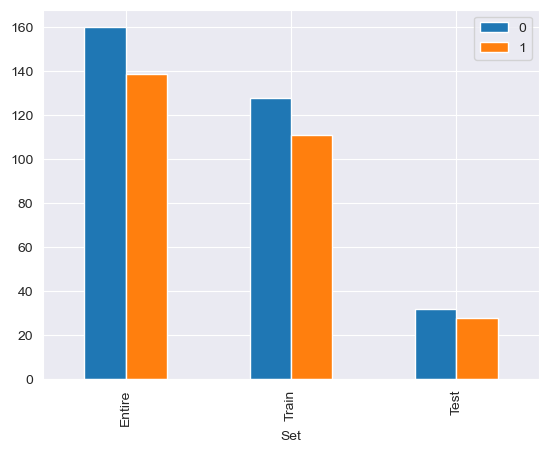

In [155]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
X_train, X_test, Y_train, Y_test = ev.scale_and_split(X, y)

# Display the counter for '1' and '0' in y set before splitting.
print('Class count before and after split (stratified).')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(Y_train)}.')
print(f'Test-set    : {Counter(Y_test)}.')

y_set_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
        ['Train', Counter(Y_train).get(0), Counter(Y_train).get(1)],
        ['Test', Counter(Y_test).get(0), Counter(Y_test).get(1)], ]
# print(data)
pd.DataFrame(y_set_data, columns=['Set','0','1']).set_index('Set').plot.bar();


Evaluation name: std-base.
Params         :{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}.

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


Confusion Matrix


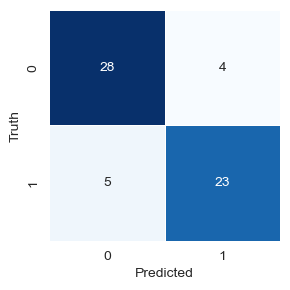

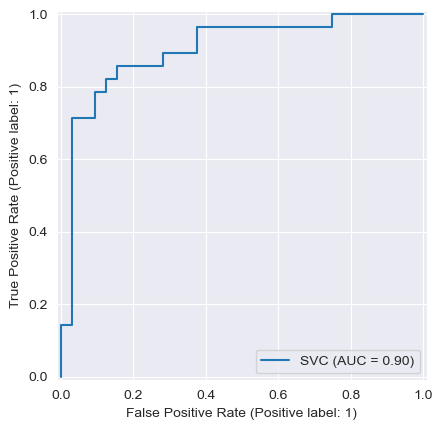

In [162]:
# Evaluation: Standard Base
build_and_validate_base_model(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_base)


Evaluation name: std-grid-scv.
Best params         :{'C': 2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}.
Best score (*mean)  :0.8286347517730498.

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Confusion Matrix


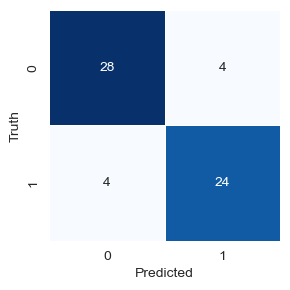

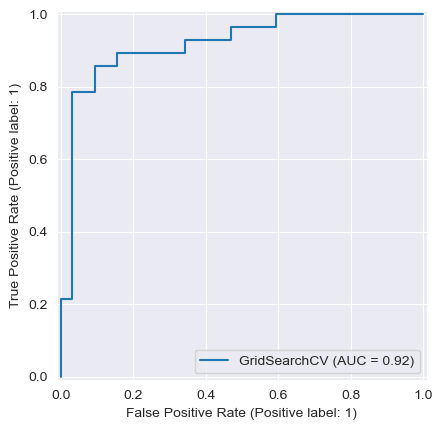

In [166]:
# Evaluation: Standard Grid Search CV
build_and_validate_with_grid_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_grid_search_cv)


Evaluation name: std-rand-scv.
Best params         :{'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 3}.
Best score (*mean)  :0.7947695035460993.

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.77      0.82      0.79        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60


Confusion Matrix


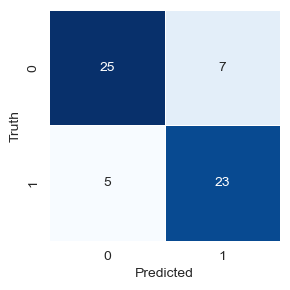

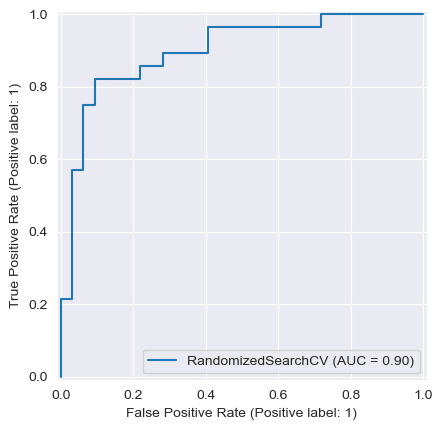

In [197]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_random_search_cv)

In [198]:
print(ev.accuracies)

{'std-base': 85, 'std-grid-scv': 87, 'std-rand-scv': 80}


## Evaluation with Oversampled Dataset (with class balancing)

### Data Preparation and Oversampling

Class counter (stratified).
Entire-set  : Counter({0: 160, 1: 160}).
Train-set   : Counter({0: 128, 1: 128}).
Test-set    : Counter({1: 32, 0: 32}).


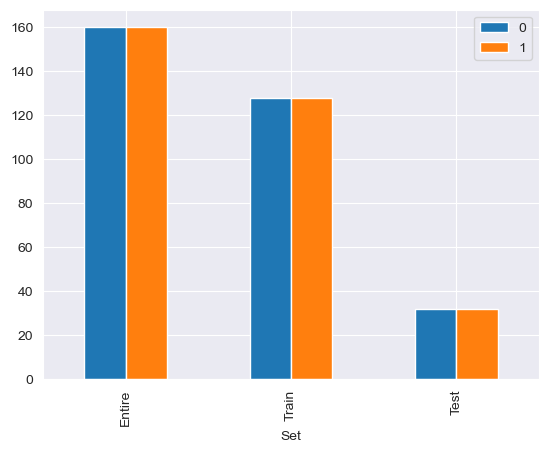

In [202]:
# Prepare features and target variables from original data frame.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE().fit_resample(X, y)

# Scale and spit the oversampled data.
Xb_train, Xb_test, Yb_train, Yb_test = ev.scale_and_split(X_b, y_b)
# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified).')
print(f'Entire-set  : {Counter(y_b)}.')
print(f'Train-set   : {Counter(Yb_train)}.')
print(f'Test-set    : {Counter(Yb_test)}.')

y_set_data = [['Entire', Counter(y_b).get(0), Counter(y_b).get(1)],
        ['Train', Counter(Yb_train).get(0), Counter(Yb_train).get(1)],
        ['Test', Counter(Yb_test).get(0), Counter(Yb_test).get(1)], ]
# print(data)
pd.DataFrame(y_set_data, columns=['Set','0','1']).set_index('Set').plot.bar();

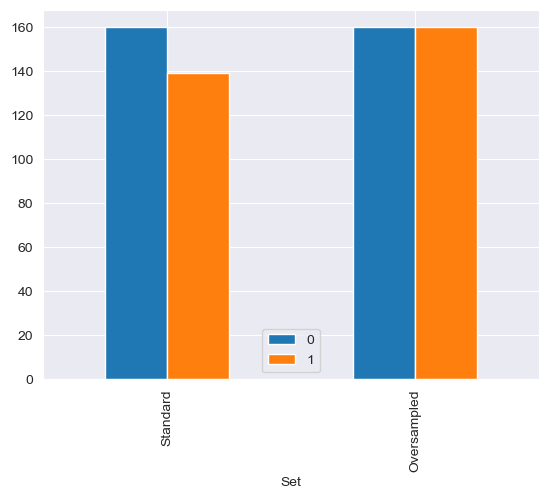

In [203]:
# Before and after oversampling
target_set_data = [['Standard', Counter(y).get(0), Counter(y).get(1)],
                   ['Oversampled', Counter(y_b).get(0), Counter(y_b).get(1)]]

pd.DataFrame(target_set_data, columns=['Set','0','1']).set_index('Set').plot.bar();


Evaluation name: os-base.
Params         :{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}.

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.81      0.81      0.81        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64


Confusion Matrix


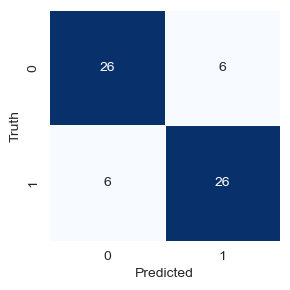

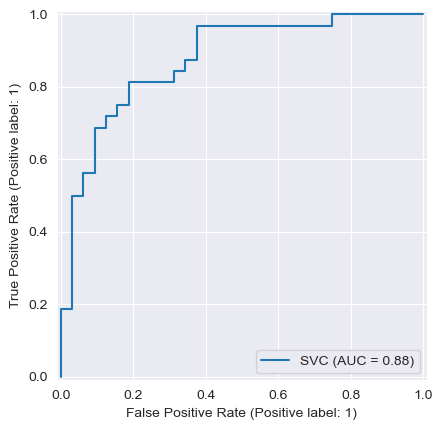

In [207]:
# Evaluation: Over-sampled Base
build_and_validate_base_model(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_base)


Evaluation name: os-grid-scv.
Best params         :{'C': 5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}.
Best score (*mean)  :0.8435143288084465.

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.81      0.81      0.81        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64


Confusion Matrix


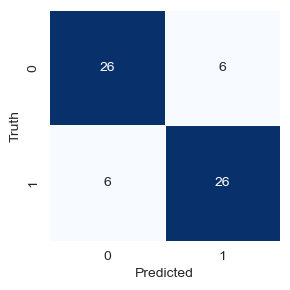

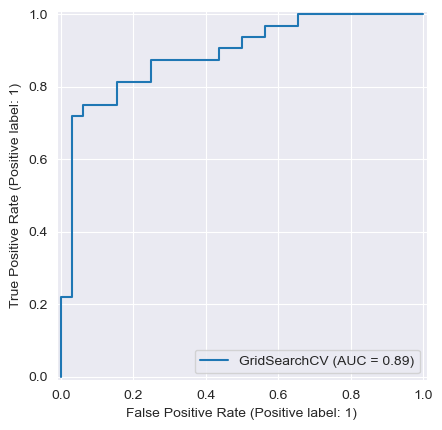

In [210]:
# Evaluation: Over-sampled Grid Search CV
build_and_validate_with_grid_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_grid_search_cv)


Evaluation name: os-rand-scv.
Best params         :{'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 5}.
Best score (*mean)  :0.8242835595776773.

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        32
           1       0.76      0.69      0.72        32

    accuracy                           0.73        64
   macro avg       0.74      0.73      0.73        64
weighted avg       0.74      0.73      0.73        64


Confusion Matrix


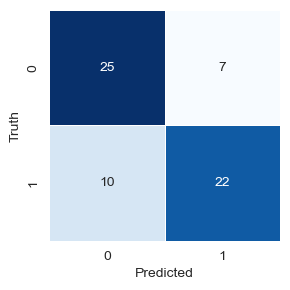

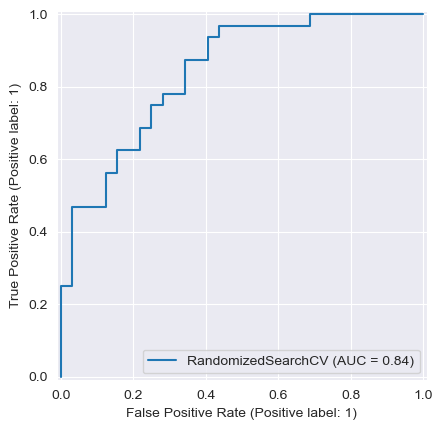

In [219]:
# Evaluation: Over-sampled Random Search CV
build_and_validate_with_random_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_random_search_cv)

In [220]:
print(ev.accuracies)

{'std-base': 85, 'std-grid-scv': 87, 'std-rand-scv': 80, 'os-base': 82, 'os-grid-scv': 82, 'os-rand-scv': 74}


## Conclusion

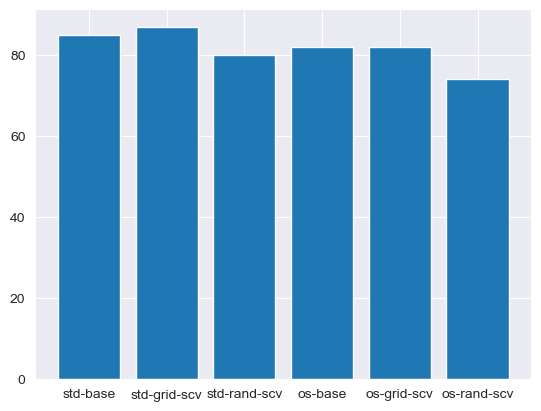

In [221]:
plt.bar(range(len(ev.accuracies)), list(ev.accuracies.values()), align='center')
plt.xticks(range(len(ev.accuracies)), list(ev.accuracies.keys()))

plt.show()

In [222]:
### Register the highest in global
ev.global_accuracies['SVM'] = 87